---

# Machine Learning practico con la ayuda de Python
# Capitulo 10: Agregamiento

## Aldo Humberto Romero 

### BUAP, Marzo, 2022
---

In [1]:
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext watermark
%watermark

Last updated: 2022-04-26T11:52:49.442716+02:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.0.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import scipy

In [4]:
%watermark -iv

scipy     : 1.8.0
sklearn   : 1.0.2
pandas    : 1.4.1
numpy     : 1.21.5
matplotlib: 3.5.1



# Donde estamos en el mapa?

<img src="fig/ml_map.png" width="700" height="200" title="Precision vs Recall" alt="Precision vs Recall"></a>

# Agregamiento (Clustering)

Agregamiento es una metodo de aprendizaje no supervisados en el que nosotros extraemos referencias desde datos de entrada que no han sido etiquetados. Generalmente, este proceso es usando para encontrar "sginificado" dentro de la estructura de datos, encontrar explicaciones en procesos, generar nuevas "features" y agrupar de manera inherente en un conjunto de clases. La idea es entonces clasificar los objetos sobre la base de similaridad y disimilaridad entre ellos.

En general, podemos clasificar los metodos de agregamiento como:

1. **Metodos basados en densidad**: Encontrar clusters basados en la region mas densa que tiene mas similaritdad en los datos. Estos metodos tienen muy buena precision y abilirdad para unit dos o mas clusters, dependiendo de la densidad limite. Por ejemplo DBSCAN (Density-Based Spatial Clustering of Applications with Noise), OPTICS (Ordering Points to Identify Clustering Structure) etc.

En particular, DBSCAN no requiere el numero de clusters como parametro de entrada, como es el caso de K-means. EN vez, infiere el numero de clusters basado en los datos y puede descubrir clsuters de forma arbitraria (en el caso de K-means, los clusters tienden a ser esfericos). En este caso, nosotros usamos el concepto de vecindad (ɛ-neighborhood). que cuenta el numero de puntos alrededor de un punto dado dentro de la esfera n-dimensional de radio ɛ y define la densidad como el numero de puntos dentro de la esfera dividido por el volumen de la esfera. El proposito es entonces identificar las vecindades de mas alta densidad, pero que el valumen de cada una de estas vecindades sea relativamente pequeño. 

DBSCAN requiere dos parametros, ɛ, que identifica que tan cercano pueden estar los puntos con respecto a los demas para ser considerado en el mismo cluster. Si la distancia entre dos puntos es menor que ɛ, entonces los consideramos en el mismo cluster. El segundo parametro define el minimo numero de puntos que definen un cluster (region densa). Una representacion del metodo, tomada de [Wikipedia](https://en.wikipedia.org/wiki/DBSCAN) es:

<img src="fig/DBSCAN-Illustration.svg.png" width="700" height="200" title="DBSCAN" alt="DBSCAN"></a>


2. **Metodos basados en jerarquias**: Los clusters creados usando este metodo forman un tipo de estructura de arbol basados en jerarquias, tambien llamado dendogramas. Se clasifican de dos maneras, aglomerativos y divisivos. Para entenderlos veamos cada uno con un poco mas de detalle.

*Aglomerativos*. El algoritmo comienza definiendo que cada dato es un cluster individual. En cada iteracion, clusters similares se unen hasta que solo K-clusters son definidos al final. Por supuesto, la clave en este algoritmo es como se define la proximidad entre dos clusters. Mas aun, siempre se calcular una matriz de proximidad que mide que tan "cerca" esta un cluster de los demas y en cada iteracion solo unimos dos que estan muy cerca. La figura a continuacion representa el dendograma del proceso, imagen tomada de [DisplayR](https://www.displayr.com/what-is-dendrogram/).


<img src="fig/What-is-a-Dendrogram.png" width="700" height="200" title="Dendobrama" alt="Dendograma"></a>

*Divisivo*. Este metodo no es muy usado en aplicaciones, pero es bueno tenerlo en mente. En la etapa inicial, todos los puntos son considerados en el mismo cluster y en cada iteracion, separamos puntos que no sean tan parecidos. 

Como dije anteriormente, la clave para estos algoritmos es como se define la matriz de proximidad. Basicamente las funciones mas usadas son, MAX, MIN, PROMEDIO, DISTANCIA ENTRE CENTROIDES, etc. Por ejemplo, el caso de MIN o tambien denominado el algoritmo de enlace simple puede definirse tal que la similaridad de dos clusters, C1 y C2 es igual al minimo de la similaridad entre dos puntos Pi y Pj, tal que Pi pertenece a C1 y Pj pertenece a C2. La similaridad se puede medir usando diferentes maneras pero las mas usuales son la distancia de Jaccard y la similitud del coseno:

$$
\text{Indice de Jaccard} = \frac{\text{el numero que esta en ambos conjuntos}}{\text{el numero qe esta en cualquiera de los conjuntos} * 100} \;\;\;\;\; \text{Distancia de Jaccard}=1-\text{Indice de Jaccard}
$$

$$
 \text{simularidad del coseno} = \frac{\vec{A} \cdot \vec{B}}{‖𝐴‖‖𝐵‖}
$$

Por ejemplo, en el caso del Indice de Jaccard, esto se puede calculate muy facil, tomemos dos conjuntos de strings y queremos mirar que tan similares son:

```
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))
```


Volviendo a los metodos divisivos, hay varios que se pueden encontrar en la literatura: CURE (Clustering Using Representatives), BIRCH (Balanced Iterative Reducing Clustering and using Hierarchies), etc.

Tomemos un caso, solo para darnos una idea como funciona, CURE.

CURE asume distancia euclidiana entre los puntos, tiene el beneficio que los clusters que encuentra pueden tener cualquier forma y por ultimo, y lo mas importante, usa una coleccion de puntos representativos para representar cada uno de los clusters (no solo un punto como el caso de K-means). Es uno de los algoritmos mas usados cuando el conjunto de datos es muy grande, tanto que no cabe en la memoria RAM de la maquina. Este algoritmo esta basado en dos pasos.  

+ Paso 1: Escoja un conjunto de puntos completamente aleatorios dentro de la base de datos. Luego use cualquier metodo de clusters jerarquicos que de los clusters iniciales. Luego escogemos puntos representaticos de estos clusters, por ejemplo $k$ (por ejemplo, el primero aleatorio, el siguiente tan lejos como se pueda y asi sucesivamente). Esto lo hacemos escogiendo un numero dado de puntos del cluster que esten lo suficientemente espaciados. Luego mueva estos puntos una fraccion fija (~20%) en la direccion del centroide del cluster (puntos sinteticos). Estos puntos sera los puntos representativos de cada cluster. 

+ Paso 2: Ahora vaya sobre todo el conjunto de datos y a cada punto de la base de datos, medimos su distancia con respecto a los puntos representativos de cada cluster y le asignamos el cluster que tenga una distancia menor a uno de los puntos representativos. 



3. **Metodos de particion**: Estos metodos de particion dividen los objetos en $k$-clusters y cada particion forma un cluster. Estos algoritmos minimizan un criterio de clustering en particular iterando sobre los puntos y relocalizandolos en cada iteracion hasta que una particion optima se obtiene. Este metodo es usado para optimizar una funcion de similaridad dada. Ejemplos son:  K-means, CLARANS (Clustering Large Applications based upon randomized Search) etc.

Una muy buena descripcion de estos metodos lo pueden encontrar en [Report Partioning Methods](http://users.jyu.fi/~samiayr/pdf/introtoclustering_report.pdf).

4. **Metodos basados en cuadricula**: En este metodo, el espacio de datos es dividido en un numero finito de celdas que forman una cuadricula. Comenzamos por definir el conjunto de celdas dentro de la cuadricula y luego asignando elementos a cada una de las celdas en la cuadricula. La densidad por celda es entonces calculada. Celdas que tengan una densidad mas baja que un limite son eliminadas y formamos clusters con los grupos adyacentes que tienen una densidad mayor. Hay varios metodos implementados en este tipo de algoritmos, como es el caso de STING (Statistical Information Grid), wave cluster, CLIQUE (Clustering In Quest) etc.

Por ejemplo en el caso de STING, uno divide el area donde estan los datos en una grid rectangular pero con diferentes niveles de resolucion, formando una estructura de tipo de arbol. Celdas en la parte mas alta del arbol contienen celdas en las partes mas bajas del arbol. La informacion en cada celda es primero calculada, para la cuadricula mas densa y guardada. La cuadricula mas alta en el arbol puede obtener informacion de las cuadriculas mas bajas en el arbol. Informacion que se guarda es el maximo, el minimo, el promedio, la deviacion estandar, el numero de puntos, tipo de distribucion de probabilidad, etc. La idea es que entonces comenzamos desde la parte mas alta del arbol y definimos el indice de STING (la celda es relevante o no) para una pregunta en particular (query). Calcule la probabilidad que una celda es relevante para la informacion que nos interesa dentro de un rango de confidencia. Solo "hijos" de celdas relevantes seran entonces exploradas. El proceso se repite hasta llegar a la parte mas baja del arbol. Preguntas que son tipicas (queries), encuentre el cluster de precios de casas que cuesten mas de 1millon y que tengan un area de al menos 120 m2.


Una figura que resume como trabajan estos metodos de agregamiento es:

<img src="fig/Clustering.jpeg" width="700" height="200" title="Clustering" alt="Clustering"></a>

De nuevo, mas adelante los vamos a ver en accion a algunos de ellos

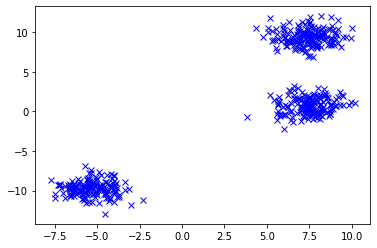

In [4]:
from sklearn import datasets

Xb, _ = datasets.make_blobs(n_samples=500, random_state=8)
#X, _ = datasets.make_circles(n_samples=1500, factor=.5, noise=.05)

plt.plot(Xb[:, 0], Xb[:, 1], 'bx')

## Introduccion – Clasificacion _vs_ Agregamiento

In [5]:
from sklearn.datasets import load_iris

In [6]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

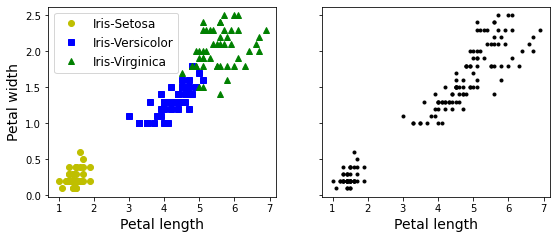

In [7]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris-Setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris-Versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris-Virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

Un modelo de mezcla Gausiana (explicado abajo) puede realmente separar estos datos en clusters, usando todas las 4 "features": longitud, ancho del petalo, longitud y ancho del sepalo.

In [8]:
from sklearn.mixture import GaussianMixture

In [9]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

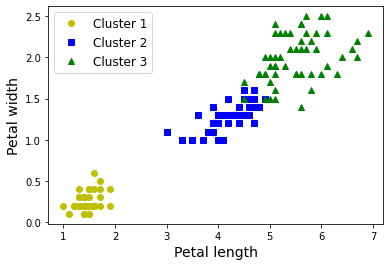

In [10]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [11]:
np.sum(y_pred==y)

145

In [12]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

# Agregamiento Kmeans

El algoritmo mas usadop para usar K-means esta basado en un proceso iterativo donde en cada iteracion hay un refinamiento de los clusters. 

Dados un conjunto inicial de clusters $k$ $m_1^{(1)}, \cdots , m_k^{(1)}$, el algoritmo procede    
[alternando entre dos etapas](http://www.inference.phy.cam.ac.uk/mackay/itila/book.html). EN otras palabras, dados los datos, comenzamos por seleccionar los centroides aleatoriamente y con eso, asignamos cada punto a uno de los $k$ clusters. 

**Etapa de asignamiento**: Asigna cada observacion al cluster que en promedio tiene la **distancia Euclidiana** mas corta. Para aquellos que han visto algo en este campo, talvez esto les recuerde a las particiones de **Voronoi**. 

\begin{equation}
S_i^{(t)} = \big \{ x_p : \big \| x_p - m^{(t)}_i \big \|^2 \le \big \| x_p - m^{(t)}_j \big \|^2 \ \forall j, 1 \le j \le k \big\},
\end{equation}

para cada $x_p$ este es asignada a solo un $S^{(t)}$, inclusive en el caso que pudiera ser asignado a dos o mas clusters.

**Estapa de actualizacion** Calcule los nuevos promedios (**centroides**) de las observaciones y defina nuevos clusters de acuerdo a la distancia. 

\begin{equation}
m^{(t+1)}_i = \frac{1}{\left|S^{(t)}_i\right|} \sum_{x_j \in S^{(t)}_i} x_j
\end{equation}

Un detalle importante, K-means es muy bueno encontrando clusters "esfericos", pero si los datos tienen formas elongadas o mas raras, fallaria. Otro detalle es que en la implementacion de Scikit, se evita que haya clusters vacios, lo que podria pasar si se repitiera el algoritmo como lo describi. Si un cluster esta vacio, Scikit encuentra el punto mas lejano de un cluster y asigna el nuevo cluster a ese punto. 

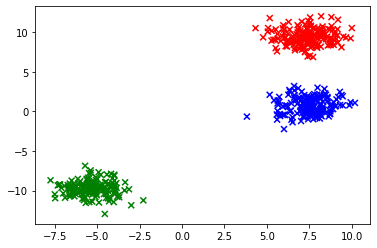

In [13]:
from sklearn import cluster

# aqui el algoritmo va a correr 10 veces, pero puede parar antes si el algoritmo encuentra la solucion antes

kmeans = cluster.KMeans(n_clusters=3, init='random',
                        n_init=1, max_iter=10, random_state=1)
C = kmeans.fit_predict(Xb)

colors = np.array(['b', 'r', 'g'])
plt.scatter(Xb[:, 0], Xb[:, 1], marker="x", c=colors[C])

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100, c=colors)

Comencemos por generar unos "blobs" como discutimos anteriormente:

In [14]:
from sklearn.datasets import make_blobs

In [15]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [16]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Ahora dibujemoslos:

In [17]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

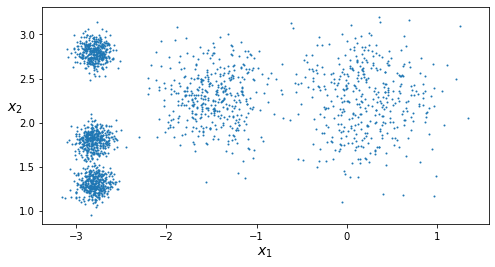

In [18]:
plt.figure(figsize=(8, 4))
plot_clusters(X)

### Ajuste y prediccion

Ahora entrenemos el K-means sobre los datos. Este tratara de encontrar cada centro de los clusters y asignar cada dato a los clusters mas cercanos.

In [19]:
from sklearn.cluster import KMeans

In [20]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Cada dato fue asignado a uno de los 5 clusters.

In [21]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [22]:
# labels_ de cada uno de los puntos
y_pred is kmeans.labels_

True

y los siguientes 5 _centroides_ son estimados

In [23]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Ahora podemos predecir los clusters para datos no vistos por el algoritmo

In [24]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

### Fronteras de decision

Ahora grafiquemos las fronteras de decision del modelo. Esto nos da un diagrama de Voronoi.

In [25]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=6,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=10, linewidths=30,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

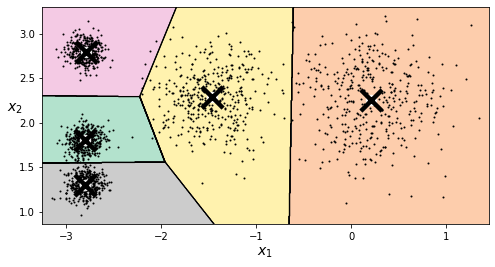

In [26]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

No esta tan mal, talvez algunos de los datos cerca de las fronteras fueron asignadas al cluster erroneo, pero en medio de todo, luce muy bien!.

### Agregamiento duro y agregamiento suave. 

Algunas veces puede ayudar a no ser tan estricto con el entrenamiento. Es decri, que en vez de arbitrariamente escoger el cluster mas cercano para cada dato (como seria el agregamiento duro), seria mejor medir la distancia de cada dato a todos los 5 centroides. Esto es lo que hace el metodo  `transform()` 

In [36]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

Se puede verificar que verdaderamente es la distancia Euclidiana entre cada punto con respecto a cada centroide.

In [37]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

In [38]:
#Aqui hemos usado la funcion tile de numpy que lo que hace es repetir un vector un numero de veces
#
print(X_new.shape)
print(X_new)
print(k)
print(np.tile(X_new, (1, k)))
#aqui el -1 hace que el reshape calcule el indice que falta
print(np.tile(X_new, (1, k)).reshape(-1, k, 2))

(4, 2)
[[ 0.   2. ]
 [ 3.   2. ]
 [-3.   3. ]
 [-3.   2.5]]
5
[[ 0.   2.   0.   2.   0.   2.   0.   2.   0.   2. ]
 [ 3.   2.   3.   2.   3.   2.   3.   2.   3.   2. ]
 [-3.   3.  -3.   3.  -3.   3.  -3.   3.  -3.   3. ]
 [-3.   2.5 -3.   2.5 -3.   2.5 -3.   2.5 -3.   2.5]]
[[[ 0.   2. ]
  [ 0.   2. ]
  [ 0.   2. ]
  [ 0.   2. ]
  [ 0.   2. ]]

 [[ 3.   2. ]
  [ 3.   2. ]
  [ 3.   2. ]
  [ 3.   2. ]
  [ 3.   2. ]]

 [[-3.   3. ]
  [-3.   3. ]
  [-3.   3. ]
  [-3.   3. ]
  [-3.   3. ]]

 [[-3.   2.5]
  [-3.   2.5]
  [-3.   2.5]
  [-3.   2.5]
  [-3.   2.5]]]


### Algoritmo K-Means

Tal y como lo hemos comentado antes, K-means es uno de los algoritmos de agregamiento mas rapidos y ademas es uno de los mas simples.

La clase `KMeans` dentro de SciKit aplica un algoritmo optimizado por defecto. Para lograr el algoritmo original de K-means, aunque no es lo mehor para hacer, deberias de usar `init="random"`, `n_init=1`y `algorithm="full"`. 

Corramos K-means, para 1, 2 y 3 iteraciones, para ver como los centroides se mueven

In [39]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=1)

Ahora grafiquemoslos

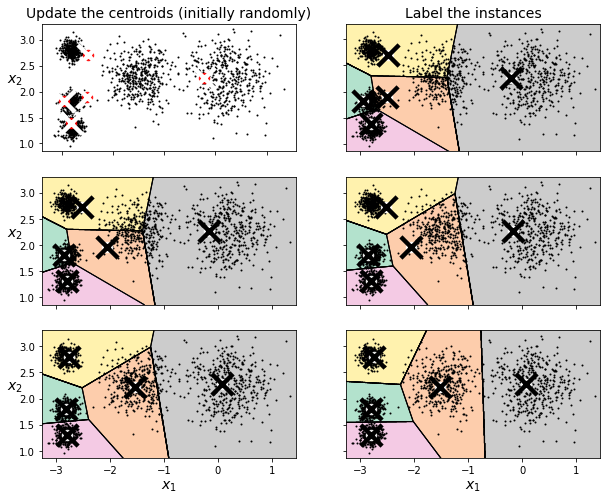

In [40]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

### Variabilidad en K-Means

En el algoritmo original de K-means, los centroides son inicializados aleatoriamente, y el algoritmo va mejorando la posicion de los centroides en cada iteracion. Sin embargo, uno de los problemas con este metodo es que si corres K-means varias veces pero con diferentes semillas aleatorias, este puede converged a diferentes soluciones.

In [46]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

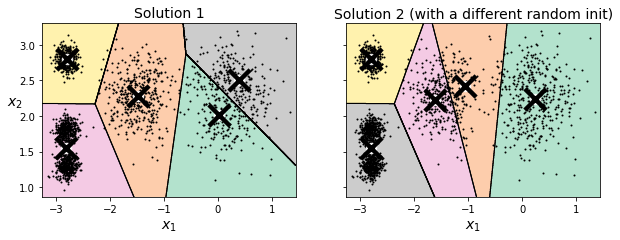

In [42]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

### Inercia

Para seleccionar el mejor modelo, nosotros necesitamos un manera de evaluar el rendimiento del modelo. Desafortunadamente, esta es una tarea sin supervision, por lo que no tenemos "resultados" para comparar (no tenemos "targets"). Lo que si podemos hacer es medir la distancia entre cada dato y su centroide, lo que es la idea de la metrica de *inercia*.

In [43]:
kmeans.inertia_

211.59853725816842

Como puede facilmente verificarse, inercia es la suma de los cuadrados de las distancias entre cada dato de entrenamiento y su centroide mas cercano.

In [44]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

El metodo `score()` regresa la inercia negativa. Porque negativa? bueno porque la idea de este metodo es respetar la regla de "entre mas grande es mejor".

In [45]:
kmeans.score(X)

-211.59853725816842

### Multiples Inicializaciones

Un metodo para revolver el problema de la variabilidad es correr el algoritmo de K-means muchas veces con diferentes inicializaciones y seleccionar la solucion que minimiza la inercia. Por ejemplo, aqui van las inercias de dos modelos malos mostrados en la figura anterior.

In [46]:
kmeans_rnd_init1.inertia_

223.2910857281904

In [47]:
kmeans_rnd_init2.inertia_

237.4624916944286

Como se puede ver, ellos tienen una inercia mas grande que el primer modelo que entrenamos, lo que hace que estos modelos sean peor.

Cuando fijamos el hiperparametro `n_init`, Scikit-Learn corre el algoritmo original `n_init` veces, y selecciona la solucion que minimiza la inercia. Por defecto, Scikit-Learn define `n_init=10`.

In [48]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=11)

Como se ve, estamos con el modelo inicial, que es verdaderamente la solucion optima (al menos en terminos de la inercia y asumiendo $k=5$).

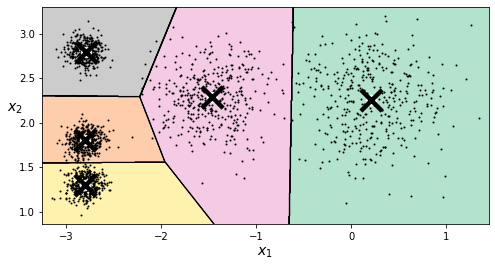

In [49]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

Una desventaja del algoritmo de K-means es que es muy sensitivo a la inicializacion de los centroides. Por ejemplo, si un centroide es inicializedo a estar en puntos muy lejanos, puede terminar con no puntos asociados a este o tambien que varios centroides queden asociados al mismo cluster, lo que resultaria en un agregamiento muy pobre. 

En esta version "mas moderna", en vez de inicializar los centroides aleatoriamente, es preferible inicializarlos usando el siguiente algoritmo descrito en [2006 paper](https://goo.gl/eNUPw6) por David Arthur y Sergei Vassilvitskii:



Randomly select the first centroid from the data points.
For each data point compute its distance from the nearest, previously chosen centroid.
Select the next centroid from the data points such that the probability of choosing a point as centroid is directly proportional to its distance from the nearest, previously chosen centroid. (i.e. the point having maximum distance from the nearest centroid is most likely to be selected next as a centroid)
Repeat steps 2 and 3 until k centroids have been sampled


* Tome un centroide $c_1$, aleatoriamente de los datos.
* Para cada punto calcule la distancia entre el mas cercano o el centroide previamente escogido.
* Selecciones el siguiente centroide de los datos tal que la probabilidad de escoger un punto como centroide es directamente proporcional a la distancia del mas cercano, centroide previamente escogido (es decir, el punto que tiene una maxima distancia desde el centroide mas cercano es mas probable a ser elegido como el proximo centroide). La probabilidad es entonces $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ donde $D(\mathbf{x}_i)$ es la distancia entre el punto $\mathbf{x}_i$ y el centroide mas cercano que fue escogido. 
* Repita las etapas anteriores hasta que todos los centroides hayan sido escogidos. 

El resto del algoritmo K-Means++ es igual al de K-Means. Para ver como "internamente lo hace" Scikit, dejenme mostrarles las implementacion:

/var/folders/sd/7rq2vwcx7fd8stfzsvfnz9980000gq/T/ipykernel_50210/3902552160.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_03 = np.array([[1.2, 0.5], [0.5, 1,3]])
/var/folders/sd/7rq2vwcx7fd8stfzsvfnz9980000gq/T/ipykernel_50210/3902552160.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov_04 = np.array([[1.2, 0.5], [0.5, 1,3]])


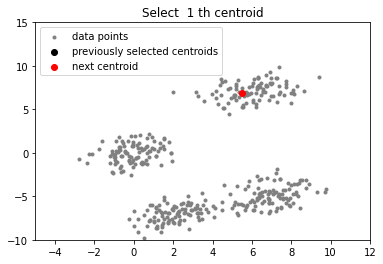

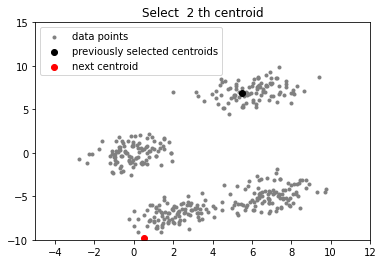

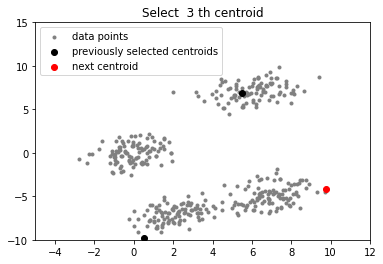

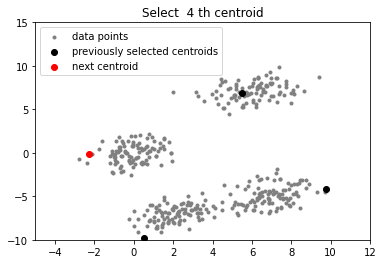

In [51]:
import pandas as pd
import sys
  
# creating data
mean_01 = np.array([0.0, 0.0])
cov_01 = np.array([[1, 0.3], [0.3, 1]])
dist_01 = np.random.multivariate_normal(mean_01, cov_01, 100)
  
mean_02 = np.array([6.0, 7.0])
cov_02 = np.array([[1.5, 0.3], [0.3, 1]])
dist_02 = np.random.multivariate_normal(mean_02, cov_02, 100)
  
mean_03 = np.array([7.0, -5.0])
cov_03 = np.array([[1.2, 0.5], [0.5, 1,3]])
dist_03 = np.random.multivariate_normal(mean_03, cov_01, 100)
  
mean_04 = np.array([2.0, -7.0])
cov_04 = np.array([[1.2, 0.5], [0.5, 1,3]])
dist_04 = np.random.multivariate_normal(mean_04, cov_01, 100)
  
data = np.vstack((dist_01, dist_02, dist_03, dist_04))
np.random.shuffle(data)

# aqui creamos los datos, asumiendo que tenemos 4 centroides
  
# Esta funcion es solo para graficar los centroides
def myplot(data, centroids):
    plt.scatter(data[:, 0], data[:, 1], marker = '.',
                color = 'gray', label = 'data points')
    plt.scatter(centroids[:-1, 0], centroids[:-1, 1],
                color = 'black', label = 'previously selected centroids')
    plt.scatter(centroids[-1, 0], centroids[-1, 1],
                color = 'red', label = 'next centroid')
    plt.title('Select % d th centroid'%(centroids.shape[0]))
     
    plt.legend()
    plt.xlim(-5, 12)
    plt.ylim(-10, 15)
    plt.show()
          
# para calcular la distancia euclidiana
def distance(p1, p2):
    return np.sum((p1 - p2)**2)
  
# Inicializacion del algoritmo
def initialize(data, k):
    '''
    initialized the centroids for K-means++
    inputs:
        data - numpy array of data points having shape (200, 2)
        k - number of clusters
    '''
    ## initialize the centroids list and add
    ## a randomly selected data point to the list
    centroids = []
    centroids.append(data[np.random.randint(
            data.shape[0]), :])
    myplot(data, np.array(centroids))
  
    ## compute remaining k - 1 centroids
    for c_id in range(k - 1):
         
        ## initialize a list to store distances of data
        ## points from nearest centroid
        dist = []
        for i in range(data.shape[0]):
            point = data[i, :]
            d = sys.maxsize
             
            ## compute distance of 'point' from each of the previously
            ## selected centroid and store the minimum distance
            for j in range(len(centroids)):
                temp_dist = distance(point, centroids[j])
                d = min(d, temp_dist)
            dist.append(d)
             
        ## select data point with maximum distance as our next centroid
        dist = np.array(dist)
        next_centroid = data[np.argmax(dist), :]
        centroids.append(next_centroid)
        dist = []
        myplot(data, np.array(centroids))
    return centroids
  
# call the initialize function to get the centroids
centroids = initialize(data, k = 4)

Ahora veamos como es el caso de Sciki y lo que tenemos que hacer es usar la inicializacion de 
K-Means++, sencillamente incluyendo `init="k-means++"` (que hasta el momento es el default):

In [52]:
KMeans()

KMeans()

In [53]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

### K-Means Acelerado

El algoritmo K-means se puede acelerar basntate si evitamos muchas de los calculos de distancia innecesarios, esto se logra explotando el famoso teorema de la inegualdad del triangulo. Dados 3 puntos, A, B y C, la distancia AC siempre es d(AC) ≤ d(AB) + d(BC). Esto nos diria que siempre la distancia entre AC estara acotada por el maximo, pero para que nos sea util, tenemos que saber acotar por el minimo. Para eso, hacemos uso de dos lemas:

+ Dados 3 puntos cualesquiera $x$, $b$, y $c$, Si $d(b, c) ≥ 2d(x, b)$ entonces $d(x, c) ≥ d(x, b)$.
+ Dados 3 puntos cualesquiera $x$, $b$, y $c$, $d(x, c) ≥ max\{0, d(x, b) − d(x, c)\}$

Ahora describimos como usar Lema 1 y 2 para evitar calculos de distancias. 

Usando el Lema 1

Sea $x$ uno de los puntos, $c$ el centro al cual $x$ esta asignado y sea $c′$ uno de los otros centros. 

(a) Si $d(x, c) ≤ \frac{1}{2} d(c, c′) \;\; \Rightarrow \;\; d(x, c) ≤ d(x, c′)$. Por lo tanto no tenemos que calcular $d(x, c′)$.

(b) Si $d(x,c)$ no se conoce exactamente, pero conocemos un limite superior $d(x,c) ≤ u$. Si $u ≤ \frac{1}{2} d(c,c′) \;\; \Rightarrow \;\; d(x, c) ≤ d(x, c′ )$. No necesitamos calcular $d(x, c′ )$.

(c) Si $u ≤ \frac{1}{2} min_{c′ ̸=c} \{d(c, c′ )\} \;\; \Rightarrow \;\; $ $x$ permanece asignado a $c$ y no hay necesidad de calcular cualquier otra distancia de $x$. 

Usando el Lema 2.

Sea $x$ uno de los puntos, $b$ uno de los centros, y $b′$ la version anterior del mismo centro.  

(a) Sea $l′$ el limite inferionr en la iteracion previa, de tal manera que $d(x, b′) ≥ l′$. Entronces el limite inferior para esta iteracion, $l$, se puede inferir como $d(x, b) ≥ max\{0, d(x, b′)−d(b, b′)\} ≥ max\{0, l′−d(b, b′)\} = l$.

(b) Ahora mostramos como este limite inferior es usado. Asumamos que $x$ esta asignado al centro $c$ y sea $c′$ cualquiera otro de los centros. Sea $d(x,c) ≤ u(x)$ y $d(x,c′) ≥ l(x,c′)$, donde $u(x)$ es el limite superior en la distancia entre $x$ y el centro al cual es asignado, y  $l(x,c′)$ es el limite inferior de la distancia entre el punto $x$ y el centro $c′$. Si $u(x) ≤ l(x, c′) \;\; \Rightarrow \;\; d(x, c) ≤ u(x) ≤ l(x, c′) ≤ d(x, c′)$. Por lo tanto, no tenemos que calcular ni $d(x, c)$ o $d(x, c′ )$.


Para detalles de la implementacion pueden echarle una mirada a [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) por Charles Elkan para mas detalles).

Para usar la variante de Elkan en K-menas, solo tienen que usar `algorithm="elkan"`. Importante recordar que este metodo no funciona cuando los datos son pocos o estan muy separadas, por lo que por default, Scikit-Learn usa `"elkan"` para datos densos, y `"full"` (el algoritmo regular) para datos "dispersos".

In [27]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

111 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [28]:
%timeit -n 50 KMeans(algorithm="full").fit(X)

97.9 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Mini-Batch K-Means

Scikit-Learn tambien tiene implementado una variante de K-means que soporta mini batches o pequeños lotes (vea [este paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [29]:
from sklearn.cluster import MiniBatchKMeans

In [30]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [31]:
minibatch_kmeans.inertia_

211.65239850433207

Si el conjunto de datos no cabe en memoria, la opcion mas simple es usar la clase `memmap`, parecido a lo que usamos en ekl caso de PCA en el notebook anterior. Para mostrar como funciona, primero carguemos los datos de MNIST:

In [32]:
from six.moves import urllib
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

Ahora, escribamos esto a un `memmap`:

In [34]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [35]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

Si tus datos son tan grandes que no puedes usar `memmap`, las cosas se pueden poner un poco mas complicadas. Comencemos por escribir una funcion que carga el siguiente lote (en la vida real, tu deberias cargar los datos desde el disco duro): 

In [36]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Ahora, entrenamos el model pasandole un lote a la vez. Por lo tanto necesitamos implementar multiples inicializaciones y mantener el modelo con la mayor precision (lowest inertia).

In [37]:
np.random.seed(42)

In [38]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [39]:
best_kmeans.score(X)

-211.6257187889114

Mini-batch  o mini-lotes K-Means  es mucho mas rapido que el K-Means regular:

In [40]:
%timeit KMeans(n_clusters=5).fit(X)

69.9 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

37 ms ± 5.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Como se ve, es mucho mas rapido, pero su desempeño es usualmente mas bajo (decimos que tiene una inercia mas grande), y el problema es que esto termina siendo peor a medida que $k$ incrementa. Grafiquemos la tasa de inercia y el tiempo de entrenamiento entre el K-means con mini-batch  y el regular:

In [42]:
from timeit import timeit

In [43]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

(1.0, 100.0, 0.0, 6.0)

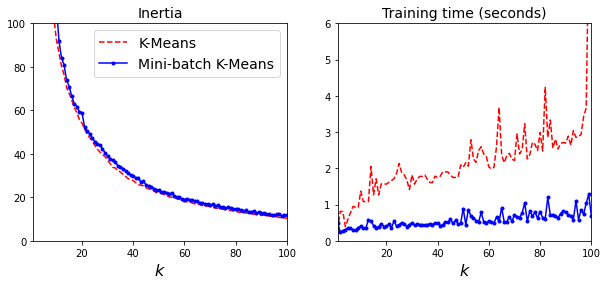

In [44]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

### Como encontrar el numero optimo de clusters

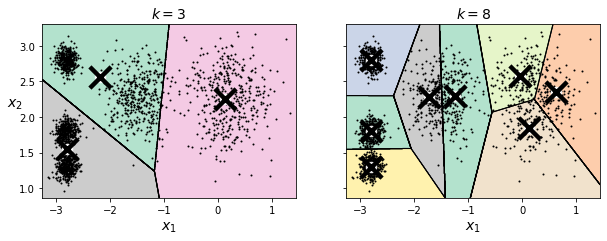

In [47]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")

Umm. estos dos modelos no se ven muy bien. Que acerca de sus inercias?

In [48]:
kmeans_k3.inertia_

653.2167190021553

In [49]:
kmeans_k8.inertia_

119.1198341610288

No, definitivamente no podemos tomar el valor de $k$ que minimiza la inercia, desde que esta sigue disminuyendo cuando incrementamos $k$. Realmente, entre mas clusters haya, e mas cercano estara cada punto a su centroide mas cercano y por lo tanto mas pequeño sera la inercia. Sin embargo, si graficamos la inercia como una funcion de $k$ y analizamos el resultado de la curva se puede observar lo siguiente:

In [50]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

(1.0, 8.5, 0.0, 1300.0)

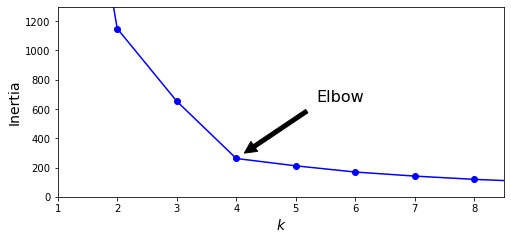

In [51]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])

Como se puede ver, hay un hombro en $k=4$, lo que significa que si tenemos menos clusters que este valor, entonces seria malo pero si tenemos mas, no ayudaria de mucho. Por lo tanto $k=4$ es una escogencia buena. Para este ejemplo no resulta ideal porque significa que dos "blobs" de la izquierda mas baja seran consideramos como un solo cluster, pero de todas maneras es una distribucion de clusters bastante decente. 

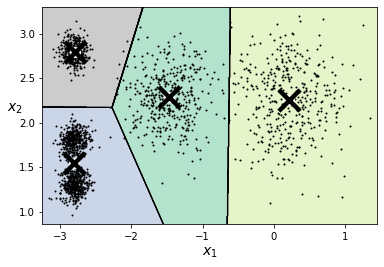

In [52]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Otro metodo es mirar el *calificacion de Silhouette*, que es el promedio del *coeficiente de Silhouette* para todos los datos. Para un dato en particular, el coeficiente de Silhouette es $(b - a)/\max(a, b)$ donde $a$ es la distancia media de todos los datos en el mismo cluster (es decir _mean intra-cluster distance_), y $b$ es la _mean nearest-cluster distance_, que es realmente la distancia media a los datos que estan en el cluster mas cercano (el que se define como el que minimiza $b$, excluyendo al que pertenece). El coeficiente de Silhouette varia entre -1 y +1; cuando es cercano a +1 significa que el dato esta muy bien dentro de su propio cluster y lejos de los otros clusters, mientras que un coeficiente cercano a 0 es que esta cercano a la frontera del cluster y por ultimo si es cercano a -1, signigica que este dato ha sido asignado al cluster erroneo.

Grafiquemos la calificacion de Silhouette como una funcion de $k$:

In [53]:
from sklearn.metrics import silhouette_score

In [54]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [55]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

(1.8, 8.5, 0.55, 0.7)

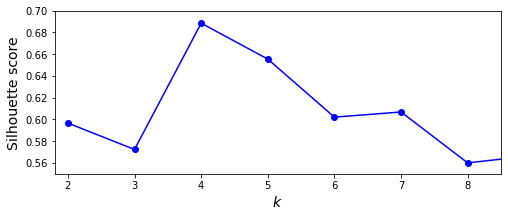

In [56]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])

Como se puede ver, esta visualizacion es mucho mas "rica" que la anterior, en particular, aunque confirma que $k=4$ es una muy buena escogencia, tambien enfatiza que el valor de $k=5$ tambien esta bien. 

Inclusive una visualizacion mas informativa es, dado que cuando tu graficas el coeficiente de Silhouette para cada dato, ordenado por el cluster al que son asignados y por el valor del coeficiente. Esta grafica es llamada _el diagrama de Silhouette_:

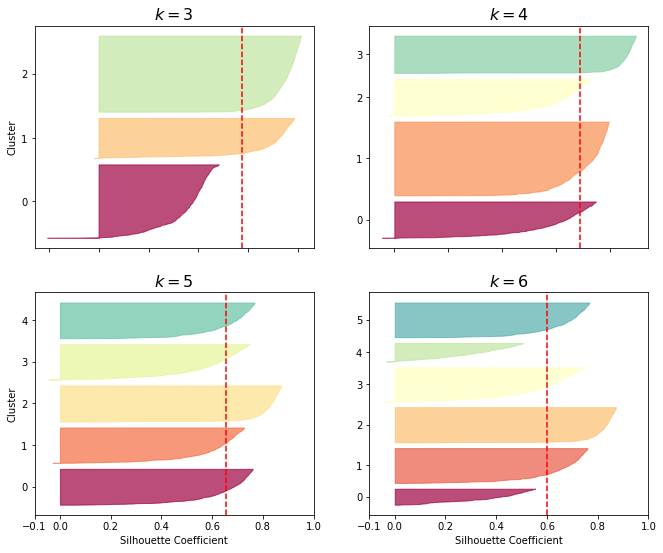

In [57]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

### Limites d K-Means

In [58]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

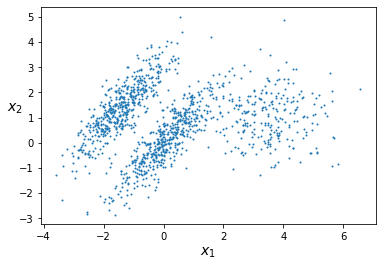

In [59]:
plot_clusters(X)

In [60]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

Text(0.5, 1.0, 'Inertia = 2179.5')

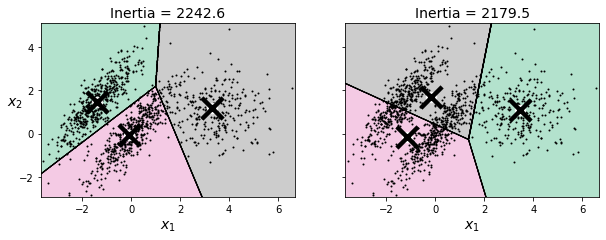

In [61]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

### Usando clustering para segmentacion de imagenes (image segmentation) 

EL metodo de segmentacion de imagenes es un metodo donde una imagen digital es dividida en subgroups llamados segmentos de la imagen y que ayuda a reducir la complejidad de la imagen y que hace el procesamiento o el analisis de la imagen mas sencillo.

(533, 800, 3)

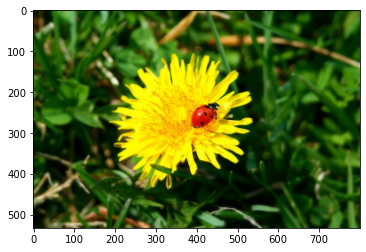

In [64]:
import os
from matplotlib.image import imread
image = imread(os.path.join("fig","ladybug.png"))
plt.imshow(image)
image.shape

In [65]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [66]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

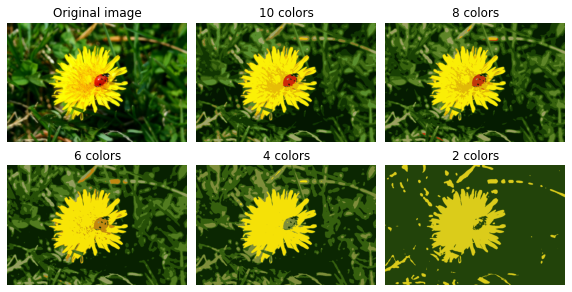

In [67]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

### Usando Clustering para Preprocesamiento

Vamoa a trabajar con el donnjunto de datos de digitos, que en su version mas sencilla es como los datos del MNIST, que contienen 1797 imagenes en scala de grises y de tamaños 8x8, representando los digitos del 0 al 9.

In [68]:
from sklearn.datasets import load_digits

In [69]:
X_digits, y_digits = load_digits(return_X_y=True)

Dividamos los datos en un conjunto para entrenar y luego para probar el algoritmo:

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Ahora usemos el modelo de regresion logistica y los evaluamos en los datos de prueba:

In [72]:
from sklearn.linear_model import LogisticRegression

In [73]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [74]:
log_reg.score(X_test, y_test)

0.9688888888888889

Okay, esa sera nuetra base, una presicion de 96.89%. Vamos a ver si podemos predecir mejhor pero ahora usando K-means como una etapa del preprocesamiento. Por lo tanto vamos a crear un proceso que primero agrega los datos de entrenamiento en 50 clusters y reemplaza las imagenes con la distancias a estos clusters, luego aplicamos el modelo de regresion logistica:

In [75]:
from sklearn.pipeline import Pipeline

In [76]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [77]:
pipeline.score(X_test, y_test)

0.9777777777777777

In [78]:
1 - (1 - 0.977777) / (1 - 0.968888)

0.28570969400874346

Como les parece? Hemos reducido el error por mas de 28%!. Pero nosotros hemos escogido el numero de clusters $k$ arbitrariamente, por lo que seguro que podemos mejorar. Desde K-means es solo una etapa de preprocesamiento es un "flujo" de clasificacion, encontrar unb buen valor de $k$ es mas sencillo que antes, no hay necesidad de realizar un analisis de Silhouette o minimizar la inercia, el mejor valor de $k$ es simplemente aquel que da la mejor clasificacion.

In [79]:
from sklearn.model_selection import GridSearchCV

In [80]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.1s
[CV] END ...............................kmeans_

[CV] END ..............................kmeans__n_clusters=35; total time=   5.1s
[CV] END ..............................kmeans__n_clusters=36; total time=   6.0s
[CV] END ..............................kmeans__n_clusters=36; total time=   6.7s
[CV] END ..............................kmeans__n_clusters=36; total time=   6.4s
[CV] END ..............................kmeans__n_clusters=37; total time=   9.5s
[CV] END ..............................kmeans__n_clusters=37; total time=  12.8s
[CV] END ..............................kmeans__n_clusters=37; total time=   9.6s
[CV] END ..............................kmeans__n_clusters=38; total time=  20.6s
[CV] END ..............................kmeans__n_clusters=38; total time=  20.0s
[CV] END ..............................kmeans__n_clusters=38; total time=  23.6s
[CV] END ..............................kmeans__n_clusters=39; total time=   9.2s
[CV] END ..............................kmeans__n_clusters=39; total time=   6.5s
[CV] END ...................

[CV] END ..............................kmeans__n_clusters=69; total time=  10.1s
[CV] END ..............................kmeans__n_clusters=70; total time=   9.0s
[CV] END ..............................kmeans__n_clusters=70; total time=   8.2s
[CV] END ..............................kmeans__n_clusters=70; total time=   8.8s
[CV] END ..............................kmeans__n_clusters=71; total time=   9.6s
[CV] END ..............................kmeans__n_clusters=71; total time=   8.2s
[CV] END ..............................kmeans__n_clusters=71; total time=   9.6s
[CV] END ..............................kmeans__n_clusters=72; total time=   8.8s
[CV] END ..............................kmeans__n_clusters=72; total time=   9.6s
[CV] END ..............................kmeans__n_clusters=72; total time=   7.3s
[CV] END ..............................kmeans__n_clusters=73; total time=   9.6s
[CV] END ..............................kmeans__n_clusters=73; total time=   9.4s
[CV] END ...................

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [81]:
grid_clf.best_params_

{'kmeans__n_clusters': 88}

In [82]:
grid_clf.score(X_test, y_test)

0.9822222222222222

La precision mejoro bastante con $k=99$, por lo tanto 99 sera!.

### Clustering para aprendizaje Semi-supervisado

Otro caso donde clustering puede ser muuy utill es en aprendizaje semi supervisado, donde tenemos un buen numero de datos que no hay sido etiquetados y donde tenemos solo algunos que estan etiquedatos.

Por ejemplo, miremos la precision del modelo de regresion logistica cuando solo tenemos 50 datos etiquetados:

In [83]:
n_labeled = 50

In [84]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

Como vamos, es inferior a lo que teniamos antes. Ahora veamos como podemos mejorar. Primero, agregemos el conjunto de entrenamiento en 50 clusters, y luego para cluster encontremos la imagen que esta mas cercana al centroide. Vamos a llamar estas imagenes, las imagenes representativas:

In [85]:
k = 50

In [86]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Ahora grafiquemos estas imagenes representativas y marquemoslas manualmente:

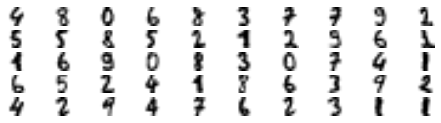

In [87]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

In [88]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

Ahora ya tenemos un conjunto de datos con 50 datos etiquetados, pero en vez de ser datos completamente aleatorios, cada uno de ellops es una imagen representativa de su cluster. Con esto, veamos si podemos tener mas precision:

In [89]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

Wow! Saltamos de tener 83.3% a tener 92.2%, sin embargo solo hemos entrenado el modelo con 50 datos. Debemos notar, que el etiquetar datos puede ser muy costoso y muchas veces muy doloroso y costoso (porque tiene que ser etiquetado por expertos), es entonces una buena idea solo etiquetar los datos representativos en vez de datos aleatorios.

Inclusive podemos ir un poco mas alla, y si propagamos las etiquetas de todos los datos que estan en el mismo cluster?

In [90]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [91]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [92]:
log_reg.score(X_test, y_test)

0.9333333333333333

Bueno, logramos una  mejora, aunque algo insignificante, pero mejopr que nada. Lo que debimos haber hecho es propagar las etiquetas solo de los datos mas cercanos al centroide, porqie si propagamos todo el cluster, es muy probable que estemos incluyendo algunos "outliers". Por ejemplo, propaguemos las etiquetas del 20% mas cercano al centroide:

In [93]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [94]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [95]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [96]:
log_reg.score(X_test, y_test)

0.94

Hermoso!! con solo 50 datos etiquetados (solo 5 ejemplos por clase en promedio!), logramos una exactitud del 94%, que es muy cercano a la regresion logistica cuando usamos todos los datos etiquetados!!.

Estio es porque las etiquetas propagadas son bastante buenas, por lo que al final su precision se acerco casi al 99%.

In [97]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896907216494846

Ahora podriamos hacer algunas iteracion de _active learning_:
1. Manualmente etiquetas los datos que el clasificados esta menos seguro, y si es posible escogerlos de clusters distintos.
2. Entrenar un nuevo modelo con estas etiquetas adicionales.

## Clustering espacial basados en la densidad y aplicaciones con ruido (DBSCAN) 

Este metodo esta basado en como definimos un cluster basados en la densidad de datos, muy similar a lo que explicamos antes. Debido a esto, este metodo nos permite encontrar clusters de forma arbitraria en bases de datos con ruido. Para esto, primero que todo, agrupa los puntos en donde la densidad es muy grande y luego marca a los puntos que este solos como "lejanos" (outliers), en las regiones de baja densidad. Para este proceso, se necesidad definir dos parametros, el radio de la vecindad alrededor de un punto p, el que denotamos como ε y el minimo nmero de puntos en una vecindad dad, el que denotamos como MinPts. Basados en esto, nosotros definimos tres tipos de puntos, si su densidad es alta, lo llamamos punto central, si la densidad es baja (pero todavia en la vecindad de algun punto central), lo llamamos punto frontera y finalmente, lo llamamos punto ruido, a todos los puntos que ni son uno o el otro. Tambien decimos que un punto q es "alcanzable por densidad" si desde un punto p, punto central, q esta dentro de la vecindad de p. Tambien decimos que un punto p es "alcanzable por densidad"  si desde un punto q, hay una cadena de puntos p1,....,pn, con p1=1 y pn=p, tal que pi+1 es directamente alcanzanble desde el punto pi. Entonces, un par de puntos p y q estan conectados por densidad si ellos son alcanzables por densidad desde un punto comun s. 

Basados en las anteriores definiciones, definimos un cluster como un subconjunto de datos que tiene las dos siguiente propiedades: 
(i) $\forall p,q$ si $p \in C$ y si $q$ es alcanzable por densidad desde $p$, entonces tambien $q \in C$ (ii) $\forall p, q \in C$, p y q estan conectados por densidad. 

Un simple uso se demuestra abajo. Para los que nosotros usamos le generacion de datos de SciKit que se llama make_moons, que crea dos semicirculos cruzados. Vea la descripcion en [Interleaving Circles](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)



In [98]:
from sklearn.datasets import make_moons

In [99]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [100]:
from sklearn.cluster import DBSCAN

In [101]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [102]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [103]:
len(dbscan.core_sample_indices_)

808

In [104]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [105]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [106]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [107]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [108]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

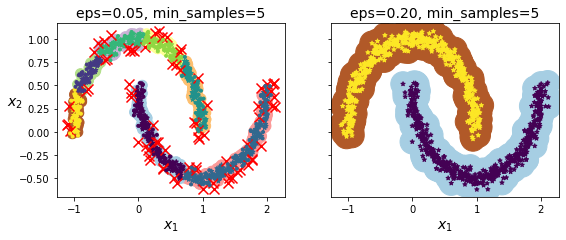

In [109]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

In [110]:
dbscan = dbscan2

In [111]:
from sklearn.neighbors import KNeighborsClassifier

In [112]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [113]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [114]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

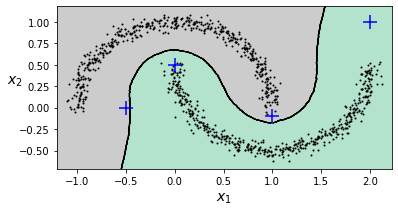

In [115]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)

In [116]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## Otros algoritmos de agregamiento

### Agregamiento Espectral

Antes de describir este algoritmo, vamos a introducir alguna notacion util voy a hacer una corta introduccion a la teoria de grafos. Esta discusion ha sido tomada de la pagina [Tutorial of Spectral Clustering](https://www.cs.cmu.edu/~aarti/Class/10701/readings/Luxburg06_TR.pdf).

Consideremos los puntos $x_1, x_2, x_3, \cdots, x_n$ (ellos podrian ser un numero o un vector) y tambien supongamos que tenemos una definicion de similaridad entre pares de datos, $s_{ij}$. 

Si nosotros suponemos que la unica correlacion entre los datos esta basado en la definicion de similaridad, podemos construir un grafo $G = (V, E)$. Donde $V_i$ son los vertices y estan representando los puntos $x_i$. Dos vertices estan conectados si la similaridad $s_{ij}$ entre los correspondientes puntos 
$x_i$  y $x_j$ es positiva (o mas grande que un umbral) y las conecciones entre vertices estan pesadas por el valor $s_{ij}$. Ahora el problema de clustering se puede reformular usando el grafo de similaridad. Nosotros queremos encontrar la particion del grafo tal que las uniones entre los diferentes grupos tiene el peso mas bajo (lo que significa que dos puntos en dos clusters diferentes son disimilares) y las conecciones entre los elementos que tienen un alto peso pertenecen al mismo cluster (son muy "parecidos") De esta manera podemos definir la matrix adyacente con pesos del grafo, $S$, que contiene los valores de similaridad entre todos los puntos. El grado de un vertice $V_i$ es obtenido calculando  $d_i = \sum^n S_{ij}$. La matriz de grado, $D$, se define como la matrix diagonal con los valores en la diagonal dados por los grados  $d_i$. 

Por lo tanto, dado un subconjunto de vertices $A \subset V$, denotamos su complemento como 
$\overline{A}$. Definimos el vector indicator $1_A =(f1,...,fn)′$  como el vector con entradas 
$f_i = 1$ Si $V_i \in A$ y $f_i = 0$ si no  es asi. Por conveniencia, introducimos la notacion reducida
$i \in A$ para el conjunto de indices $\{i | V_i \in A\}$. Nosotros consideramos dos formas diferents para medir el tamaño de un subconjunto $A \subset V$: (i) $|A|$, el numero total de vertices en $A$ (ii) vol($A$) = $\sum_{i \in A} d_i$.

Un subconjunto $A \subset V$ de un grafo esta conectado si dos vertices cualesquiera pueden unirse por un camino, de tal manera que todos los puntos intermedios tambien estan dentro de $A$. Un subconjunto 
$A$ es llamado una componente conectada, si este esta conectado y si no hay conecciones entre vertices en 
$A$ y $\overline{A}$. Los conjuntos $A_1, \cdots ,A_k$ forman una particion del grafo si  $A_i \cap A_j = \emptyset$ and $A1 \cup \cdots \cup  A_k = V$.

Ahora, ya basados en las anteriores definiciones, podemos transformar cualquier 
$x_1, \cdots, x_n$ datos a un grafo. El objetivo cuando construimos grafos de similaridad es modelar la relacion entre vecindad local  de los datos. Sin embargo, la mayoria de construcciones presentadas a continuacion pueden dar lugar a un representacion dispersa de los datos, lo cual tiene ventajas computacionales. 


1) **Grafo en vecindda ε**. Conecta todos los puntos que en distancias de pares tienen una distancia menor que  ε (grafo sin pesos).

2) **grafo de vecindad k-nearest neighbor**. Conecta vertice $V_i$ con vertice $V_j$ si $V_j$ esta entre los $k$ nearest neighbors of $V_i$. Sin embargo, esta definicion puede dar lugar a un grafo dirigido (apunta en solo una direccion), por la relacion de vecindad no es simetrica (conecciones tienemn direccion). Ahora hay dos maneras de encontrar que este grafo no sea dirigido. La primera forma es simplemente ignorar las direcciones de las uniones. Este grafo es lo que usualmente se llama como el grafo k-NN. La segunda manera es conectar los vertices  $V_i$ y $V_j$ Si $V_i$ esta entre los k-vecinos de  $V_j$ y $V_j$ esta entre los k-vecinos de $V_i$. El grafo resultante es llamado grafo mutuo de vecindad k-NN. En ambos casos, luego de conectalos los vertices apropiados, pesamos las uniones usando la similatidad de objetos adyacentes. 

3) **Grafo totalmente conectado**. Cnected todos los puntos con simularidad positiva con respecto a cada uno y pesemos todas las conecciones por $s_{ij}$. Como el grafo deberia modelar la relaciones dentro de la vecindad local, esta construccion es usualmente escogida si la funcion de similaridad en si misma de alguna manera da mas peso a las vecindades mas cercanas.

Las principales herramientas para clustering espectral son las matrices de grafo Laplacianas. Aunque no hay una definicion unica para estas matrices, voy a presentarles las mas usadas. En lo siguiente vamos a asumir que $G$ es un grafo con pesos y no dirigido, cuyos peses vienen de la matriz $W$, $w_{ij} = w_{ji} \ge 0$. Ademas cuando hablemos de los eigenvectores de una matriz, no necesariamente vamos a asumir que ellos estan normalizados a 1. Los valores propios estaran siempre orderanosw de manera incremental, respetando las multiplicidades. Por lo tanto cuando nos referimos a los primeros k-vectores propios, nos estamos refiriendo a los vectores propios que corresponden a los k valores propios mas pequeños.

a) **Grafo Laplaciano no normalizado**. $L = D − W$. Alguna de las propiedades de esta matrix puede encontrarse en [Mojan Mojar description](https://www.fmf.uni-lj.si/~mohar/Papers/Montreal.pdf). Para nuestra aplicacion aqui, la propiedad mas util dice: sea $G$ un grafo no dirigido con pesos no negativos. Entonces la multiplicidad $k$ de un valor propio $\lambda$ de $L$ es igual al numero de componentes conectados $A_1, \cdots , A_k$ en el grafo.

b) **Grafo Laplaciano normalizaco**. Hay dos definiciones utiles para este tipo de Laplaciano. $L_{sym} =  I - D^{-1/2} W D^{-1/2}$ y $L_{rw} = I - D^{-1} W $. DOnde $L_{sym}$ es una matriz simetrica y la segunda, $L_{rw}$, esta relacionada con las caminatas aleatorias. Una muy buena descripcion de esas matrices se puede encontrar en [Fan Chung graph theory website](http://www.math.ucsd.edu/~fan/research/revised.html). Adicionalmente a estas definiciones que tienen un gran numero de propiedades, las mas importante se puede resumir en el siguiente teorema: 

Sea $G$ un grafo no dirigido con pesos no negativos. Entonces, la multiplicidad $k$ del valor propio $0$ de ambos, 
$L_{rw}$ y $L_{sym}$ es igual al numero de componentes conectados $A_1, \cdots,A_k$  en el grafo. Para $L_{rw}$, el espacio propio de $0$ esta expandido por los vectores  $1_{A_i}$. Para $L_{sym}$, el espacio propio de $0$ esta
expandido por los vectores $D^{1/2} 1_{A_i}$.

Ahora con todas estas definiciones y propiedades, podemos definit el agregramiento espectral. Mientras que hay diferentes versiones, la idea es muy similar en cada una de ellas, por lo que aqui solo vamos a discutir una, pero si tu eres de lo que no se queda con lo basico, puedes explorar las otras maneras y ver los parecidos y las diferencias.

El llamado agregramiento espectral no normalizado trabaja de la siguiente manera. Primero, los datos son tomado para construir la matriz de similaridad, $S_{ij}$. Con esta informacion, y un numero predeterminado de $k$ clusters, podemos construir la matris de adyacencia, $W$. Desde esta nueva matriz, podemos calcular el laplaciano no normalizaco $L$ y encontrar sus correspondientes valores y vectores propios. Tome los vectores con los valores propios mas pequeños $V_1, \cdots, V_k$ y cree ahora entonces $V$ desde este conjunto de vectores propios. Ahora agrege los puntos que estan presentes en estos vectores propios con el  algoritmo de $k$-means en clusters $C_1, \cdots C_k$. Estos clusters corresponden a la particion buscada.

Veamos esto en accion.

In [117]:
from sklearn.cluster import SpectralClustering

In [120]:
# recuerden que gamma es el valor para el Kernel
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [121]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [122]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [123]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

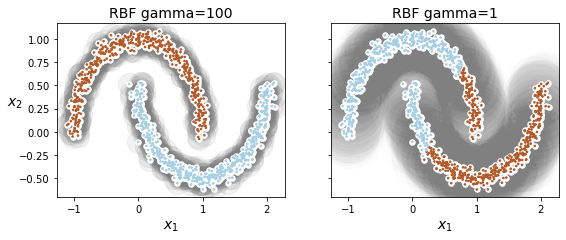

In [124]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


### Agregamiento aglomerativo

En este metodo, cada punto inicialmente es considerar un cluster individual. A cada iteracion, clusters similares se unen con otros clusters hasta que uno or K clusters son formados. Asi es como trabaja:

In [125]:
from sklearn.cluster import AgglomerativeClustering

In [126]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [127]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [128]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [129]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

# Mezclas Gausianas

Hay metodos probabilisticos en agregamiento que evitan algunos de los problemas conocidos con otros metos que es que dependen de la distancia a un centroid. En este metodo, lo que hacemos es decribir cada cluster por su centroide (promedio), covarianza y el tamaños del cluster el numero de datos en ese cluster (el peso). Esta distribucion se denora en la literatura como $\pi$. Aqui mas que identificar los clusters a traves de definis los puntos mas cercanos a un centroide, como es el caso de K-means, lo que hacemos es ajustar $k$ Gausianas a los datos. De estas, podemos estimar los parametros de la distribucion Gausiana como la media y la varianza para cada cluster y el peso de cada clusters. Esto significa  que tendremos es una distribucion de probabilidad que depende de todos estos parametros calculados $\theta = \{ \vec{\mu}, \vec{\sigma}, \vec{\pi} \}$, donde la dimensionalidad del vector corresponde al numero de Gausianas. Luego de aprender los parametros para cada dato, podemos calcular las probabilidades que este pertenezca a cada uno de los clusters de la muestra y se asignara al cluster donde la probabilidad sea la mas grande. Al final, el pertenecer a un cluster es modelado por la mezcla de distribuciones  Gausianas unimodales.

Esto no es importante pero para aquellos que tienen conocimiento en teoria de probabilidad, este metodo se puede escribir como:

\begin{equation}
P(x | \theta ) = \sum^M \pi_i  \mathcal{N} \left( x | \mu_i, \sigma_i \right)
\end{equation}

donde la suma va sobre todos los clusters.

Ahora consideremos un conjunto de observaciones que corresponden a N datos $x_n$, los que asumimos que son escogidos independientemente de la distribucion anterior. La probabilidad de los datos observados, dando los coeficientes y parametros calculados esta dada por

\begin{equation}
P(x | \theta ) = \prod_{n=1}^N \sum^M \pi_i  \mathcal{N} \left( x_n | \mu_i, \sigma_i \right)
\end{equation}


In [130]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Ahora entrenemos el modelo de mezcla Gausiana usando los datos anteriores:

In [131]:
from sklearn.mixture import GaussianMixture

In [132]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Ahora miremos los parametros que el algoritmos ha estimado:

In [133]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [134]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [135]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

el agoritmo convergio?

In [136]:
gm.converged_

True

Ok, pero cuantas iteraciones tomo?

In [137]:
gm.n_iter_

4

Ahora podemos usar este modelo para predecir a que cluster cada uno de los datos pertenece (agregamienti "duro") o las probabilidad que el punto sea encontrado en cada uno de los clusters. Para esto, solo usamos el metodo
`predict()` o el metodo `predict_proba()`:

In [138]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2])

In [139]:
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

Este es un model generativo, es decir puedes muestrear nuevas instancias del modelo y hasta saber la etiqueta:

In [140]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [141]:
y_new

array([0, 0, 1, 2, 2, 2])

Note que ellos estan siendo muestreados secuencialmente de cada cluster.

Tambien podemos estimar el "log" de la __funcion de densidad de probilidad (FDP)__ en cualquier punto usando el metodo `score_samples()`:

In [153]:
gm.score_samples(X)

array([-2.60782346, -3.57106041, -3.33003479, ..., -3.51352783,
       -4.39802535, -3.80743859])

Primero probemos que la FDP (o sus siglas en ingles PDF) integra a 1 sobre todo el espacio. Para esto tomamos un cuadrado grande alrededor de los clusters y lo cortamos en un grid de cuadrados pequeños, entonces calcularmos la probabilidad aproximada que estas instancias sean generadas en cada cuadrado pequeño (lo que se obtiene multiplicando el PDF de una esquina por el area del pequeño cuadrado y finalmene suma sobre todas las probabilidades. El resultado deberia cercano a 1.0:

In [142]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999215021

Ahora grafiquemos la frontera de decision resultante (linea punteadas) y los contornos de densidad:

In [143]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

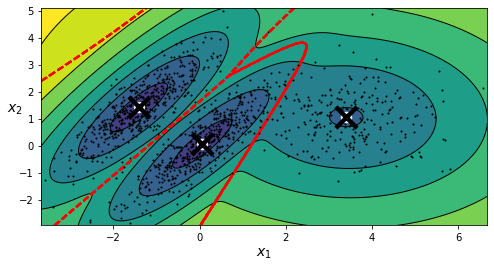

In [144]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

Ustedes pueden imponer restricciones sobre la mas matrices de covariance, lo que se hace cuando defines la variable en el algoritmo  `covariance_type` :
* `"full"` (default): no restriccion, todos los clusters pueden tomar cualquier cualquier forma elipsoidal de cualquier tamaño. 
* `"tied"`: todos los clusters deben tener la misma forma, pero aun asi pueden tener cualquier forma elipsoidal (es decir tiene la misma matriz de covarianza).
* `"spherical"`: todos los clusters deben ser esfericos, pero pueden tener diferentes diametros.
* `"diag"`: clusters pueden tomar cualquier forma elipsoidad de cualquier tamaño, pero los ejes del elipsoide deben ser paralelos entre ellos (las matrices de covarianza deben ser diagonales). 

In [145]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [146]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


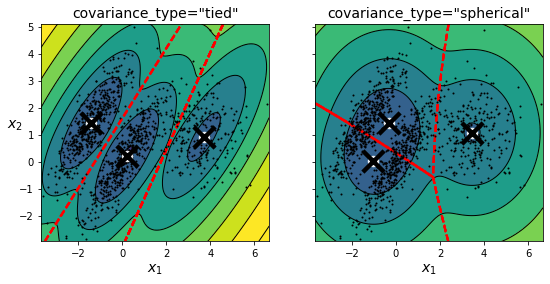

In [147]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

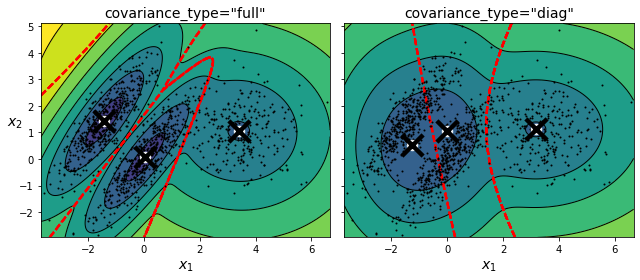

In [148]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Deteccion anomala usando mezclas gausianas 

Mexclas Gausianas pueden tambien ser usados para __deteccion de anomalias__: la idea es buscar instances localizadas en regiones de muy baja densidad que pueden ser considerados anomalias. Ustedes tienen que definir cual es el umbral en la densidad que se tiene que usar. Por ejemplo, en una compañia manofactura que trata de detectar productos defectivos, la tasa de productos defectivos es usualmente bien conocido. Por ejemplo digamos que es 4%, entoncxes uno puede definir el umbral en la densidad al valor que resulta en tener 4% de los datos localizados en areas con un densidad menos al umbral de densidad:

In [149]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

(-2.9486047751812894, 5.1)

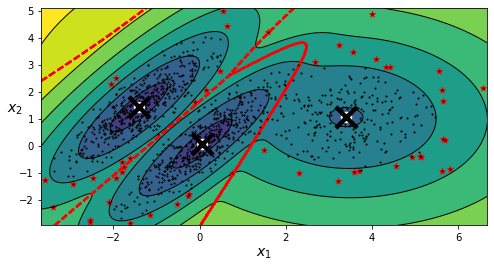

In [150]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

## Seleccion del Modelo

Nosotros no podemos usar el gradl del silhouette o la inercia porque ambas asume que los clusters son esfericos. En vez, podemos tratar de encontrar el modelo que minimiza un criterio de informacion teorica tal que el criterio de informacion Bayesiana (CIB o BIC por sus siglas en ingle) o tambien el criterio de informacion Akaike (CIA o por sus siglas en ingles AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ es el numero de instancias. 
* $p$ es el numero de parametros aprendidos por el modelo. 
* $\hat L$ es el valor maximizado de la funcion de probabilidad del modelo. Esta es la probabilidad condicional de los datos observados $\mathbf{X}$, dando el modelo y sus parametros optimizados. 


Ambos BIC y AIC penalizan aquellos modelos que tiene muchos parametros para aprender (es decir, mas clusters), en modelos de recompensa que ajustan los datos bien (es decir que los modelos que dan una alta probabilidad de los datos observados). 

In [151]:
gm.bic(X)

8189.747000497186

In [152]:
gm.aic(X)

8102.521720382148

Podemos calcular el BIC manualmene como esto:

In [153]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [154]:
bic, aic

(8189.747000497186, 8102.521720382148)

In [155]:
n_params

17

Hay un peso por cluster, pero la suma debe ser igual a 1, es decir que tenemos un grado de libertad menos, por lo tanto eso explica el -1. Similarmente, los grados de libertad $n \times n$ para una matrix de covarianza  no es $n^2$, pero $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Ahora entrenemos un modelo de mezcla Gausiana con varios valores de $k$ y midamos su BIC:

In [156]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [157]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

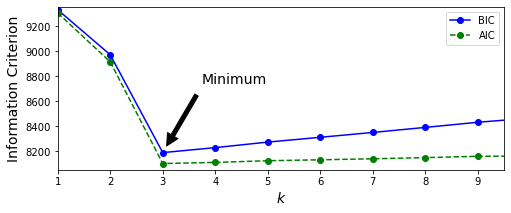

In [158]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()

Ahora busquemos la mejor combinacion de valores para el numero de clusters y el hiperparametro `covariance_type`:

In [159]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [160]:
best_k

3

In [161]:
best_covariance_type

'full'

## Mezclas Gausianas Variacionales Bayesianas

En vez de buscar manualmente por el numero optimo de clusters, es posible usar en vez el metodo de 
`BayesianGaussianMixture` que es capaz de dar pesos, inclusve cercanos a ceros, cuando los clusters son innecesarios. Solo defina el numero de componentes a un valor que usted crea que es mas grande que el numero optimo de clusters, y el algoritm eliminara los clusters innecesarios automaticamente.

In [162]:
from sklearn.mixture import BayesianGaussianMixture

In [163]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

El algoritmo automaticamente detecto que solo 3 clusters son necesarios:

In [164]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

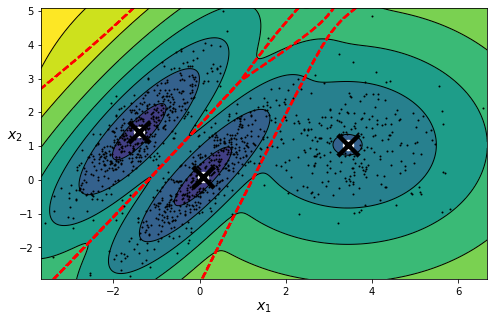

In [165]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [166]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [167]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [168]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

Text(0.5, 1.0, 'weight_concentration_prior = 10000')

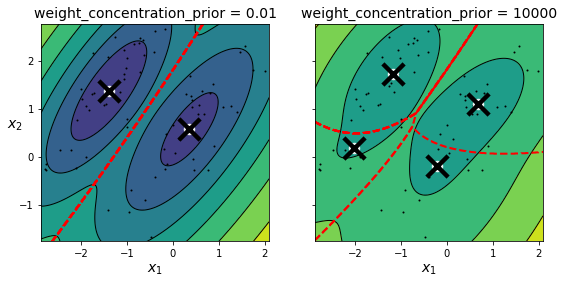

In [169]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

NotaL el hecho que veas solo 3 regiones en la grafica de la derecha, aunque haya 4 centroides no es un problema. EL peso del cluster de la parte de arriba a la derecha es mucho mas grande que el peso del cluster de la parte de abajo a la derecha, asi que la probabilidad de cualquier punto dado en esta region pertenece a la del cluster de la parte de arriba de la derecha que es mas grande que la probabilidad de si pertenece al cluster de la parte de abajo de la derecha.

In [170]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [171]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

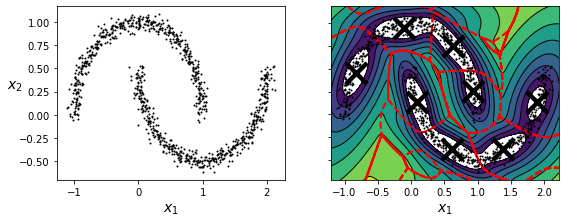

In [172]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

Umm... no se ve muy bien, en vez de detectar dos clusters en forma de luna, el algoritmo detecta 8 clusters elipsoidales. Sin embargo, la grafica de densidad luce bastante bien, por lo qe estos pueden ser usados para detecccion de anomalias. 

## Funcion de Probabilidad (likelihood function)

La funcion de "likelihood" describe la funcion de probabilidad conjunta para los datos observados como una funcion de los parametros dentro de un modelo estadistico escogido. Es decir, nos indica que tan probable una poblacion es capaz de producir la muestra de datos observada en funcion de unos parametros.
Esto quierde decir que para cada valor del parametro $\theta$, la funcion $p(\vec{X}|\theta)$ asigna una prediccion de probabilidad a los datos observados. 

En realidad, el "likelihood" no es una funcion de densidad de probabilidad de los parametros, lo que se denota como $\mathcal{L}(\theta|\vec{X}_0) = p(\vec{X}_0|\theta)$. En metodos basados en la estimacion de la maxima "likelihood", la funcion es maximizada para obtener el valor especifico $\hat{\theta} = argmax_{\theta \in \Theta} \mathcal{L}(\vec{X}|\theta)$.

De nuevo, la funcion de Likelihood no es en si misma una densidad porque su agumentos son los parametros $\theta$ de la distribucion, no el valor de la variable $\vec{X}$. Por ejemplo la integral de este funcion sobre todos los valores de $\theta$ no necesariamente debe ser igual a 1.

In [179]:
from scipy.stats import norm

In [180]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1) / (xx[1] - xx[0])

Text(0.5, 1.0, '$\\log \\, \\mathcal{L}(\\theta|x=2.5)$')

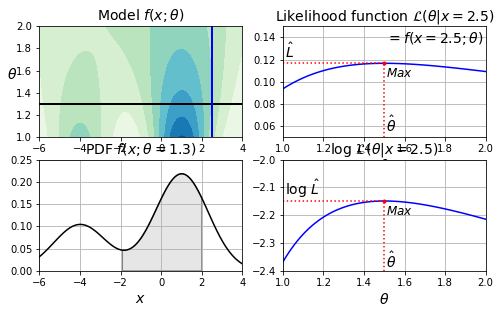

In [181]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

# Clusterina Jerarquico

Como discutimos anteriormente, la tecnica de clustering esta dividida en dos tipos (ii) aglomerativa y (ii) divisiva.


En el caso de aglomerativa, inicialmente cada dato es considerado un cluster individual. Entonces la matriz de proximidad es calculada. A cada iteracion, los clusters similares se unen con otros clusters hasta que uno cluster o K-clusters son formados. Para poder entender este proceso, se usa un diagrama que nos ayuda a ver como el proceso se crea, se llama dendograma. Un dendograma es un diagrama tipo arbol que graba las secuencias de las uniones o las divisiones.

EN el caso de clustering jerarquico divisivo, consideramos todos los puntos en un solo cluster en cada iteracion, nosotros vamos separando puntos del cluster que no son similares. Para cada punto que es separadao, es considerado como un cluster individual. Al final, nos quedamos solo con $n$ clusters. Aunque el proceso es claro, este metodo no es tan usado como el caso aglomerativo.

Hay un detalle que tiene que ser aclarado antes de discutir como se usa. Como se define la similaridad?


1) MIN. Esta version tambien se conoce como el algoritmo del enlace unico y esta basado en la deficion de similaridad que se calcula como la distancia minima entre todos los puntos dentro de dos clusters dados C1 y C2. En practica, se calcula los puntos mas cercanos dentro de los dos diferentes clusters y define esta distancia como la similaridad entre los clusters.

2) MAX. Esta similaridad es tambien llamada el algoritmo de todos los enlaces, que es el opuesto al MIN. La simil;artidad entre dos clusters, C12 y C2, es igual al maximum de la similaridad entre dos puntos $P_i$ y $P_j$, donde $P_i$ pertenece a $C_1$ y $P_j$ pertenece a $C_2$. En practica, escoja los dos puntos mas lejanos de los dos diferentes clusters y declare la similaridad entre los dos clusters como la similaritdad entre los dos puntos. 

3) Promedio del grupo. Aqui tome todos los pares de puntos y calcule sus similaridades y calcule el promedio. 

4) Distancia entre los centroides. Aqui calculas los centroides entre dos clusters $C_1$ & $C_2$ y tome la similaridad entre los dos centroides como la similaritdad entre los dos clusters. Esta es una de las tecnicas mas populares. 

5) El metodo de Ward. En este metodo, la similaridad entre los clusters es exactamente el promedio del grupo, excepto que en este metodo, se calcula la suma de los cuadrados de las distancias entre $P_i$ y $P_J$.

Bueno, ahora si veamoslo en accion.

In [182]:
from scipy.cluster.hierarchy import distance

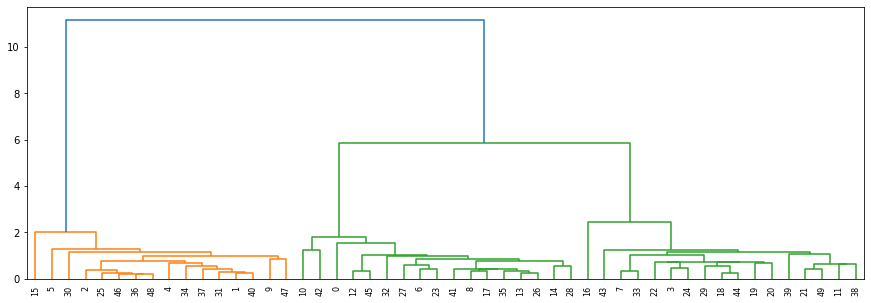

In [203]:
from scipy.cluster.hierarchy import ward, linkage, dendrogram, fcluster

X, _ = datasets.make_blobs(n_samples=50, random_state=8)
# X, _ = datasets.make_circles(n_samples=500, factor=.5, noise=.05)


Z = linkage(X)
plt.subplots(figsize=(15,5))
P = dendrogram(Z);

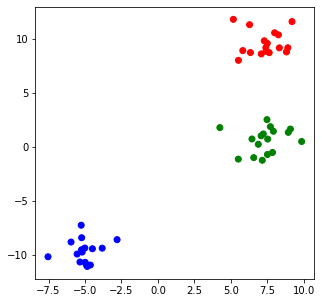

In [204]:
# Crea los clusters usando el metodo jerarquico dado una matrix de enlace
# 

T = fcluster(Z, 3, 'maxclust')
colors = np.array(['b', 'r', 'g', 'y', 'k'])

plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], color=colors[T-1]);

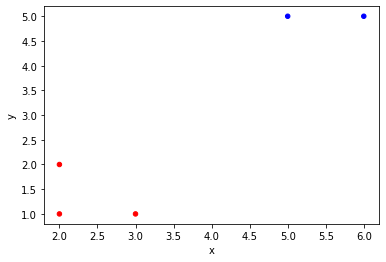

In [205]:
# Ok, como ven, visualizar los clusters es importante. uno puede usar matplotlib o seaborn
# como ejemplo veamos como se ven los dos

from matplotlib import pyplot as plt

df = pd.DataFrame({'x': [2, 3, 5, 6, 2], 
                   'y': [1, 1, 5, 5, 2],
                   'labels': ['A', 'A', 'B', 'B', 'A']}) 

colors = {'A':'red', 'B':'blue'}

df.plot.scatter(x='x', y='y', c=df['labels'].apply(lambda x: colors[x]))
plt.show()

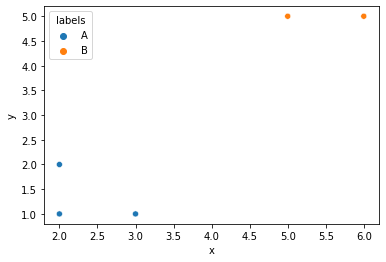

In [206]:
# hagamos los mismo con Seaborn
import seaborn as sns


df = pd.DataFrame({'x': [2, 3, 5, 6, 2], 
                   'y': [1, 1, 5, 5, 2],
                   'labels': ['A', 'A', 'B', 'B', 'A']}) 

sns.scatterplot(x='x', y='y', hue='labels', data=df)

plt.show()

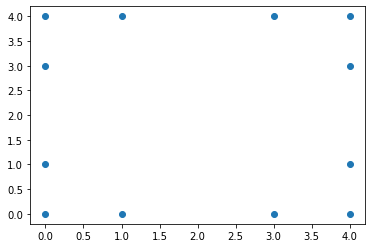

In [207]:
# Hagamoslo mas claro y sencillo
# aqui importamos ward 
# Ward hierarchical clustering: constructs a tree and cuts it.
# fcluster: Form flat clusters from the hierarchical clustering defined by the given linkage matrix.
# pdist: Pairwise distances between observations in n-dimensional space.

from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.text import TextPath


X_ejem = [[0, 0], [0, 1], [1, 0],
     [0, 4], [0, 3], [1, 4],
     [4, 0], [3, 0], [4, 1],
     [4, 4], [3, 4], [4, 3]]
X_ejem = np.array(X_ejem)
Z = ward(pdist(X_ejem))

# tenemos 12 puntos en dos dimensiones distribuidos asi
plt.plot(X_ejem[:,0],X_ejem[:,1],'o')

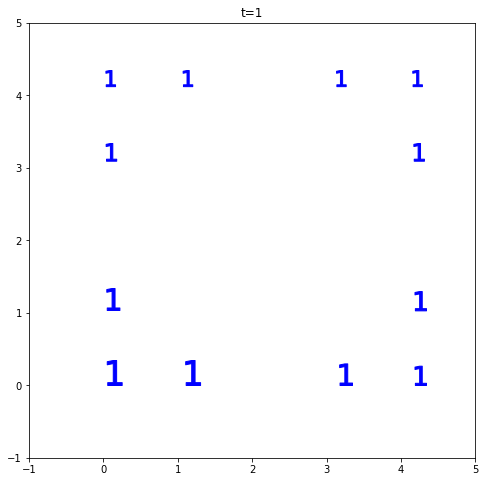

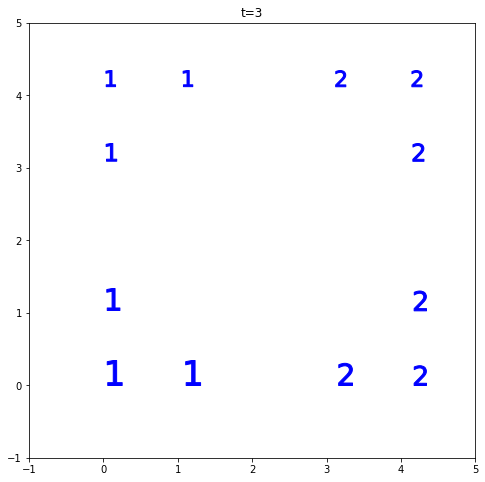

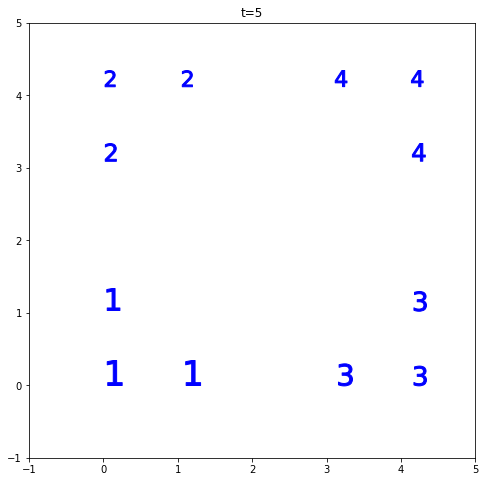

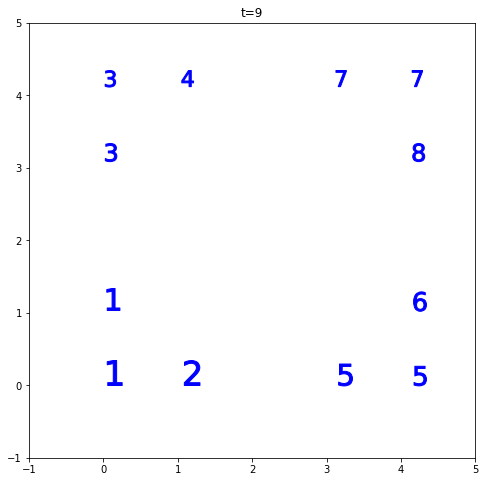

In [208]:
# veamos ahora el clustering usando "maxclust".
# para la grafica, usamos el numero al que corresponde

# Aqui el parametro t limita el numero de clusters. Si t=1, los otros criterios no son usados
# ya que todos pertenecen al mismo cluster

for tt in [1, 3, 5, 9]:
    plt.figure(figsize=(8,8))
    plt.title('t={}'.format(str(tt)))
    plt.xlim((-1,5))
    plt.ylim((-1,5))
    memberships = fcluster(Z, t=tt, criterion='maxclust')
    for ii in range(len(memberships)):
        path = TextPath((X_ejem[ii,0],X_ejem[ii,1]), str(memberships[ii]))
        plt.plot(X_ejem[ii,0],X_ejem[ii,1],marker=path,c='b',markersize=50)

    plt.show()

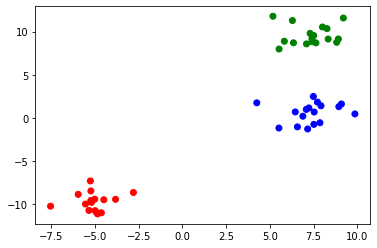

In [209]:
# veamoslo de nuevo pero para los datos que definimos antes

aggl = cluster.AgglomerativeClustering(n_clusters=3)
C = aggl.fit_predict(X)

colors = np.array(['b', 'r', 'g'])
plt.scatter(X[:, 0], X[:, 1], c=colors[C])